In [2]:
import dynamiqs as dq
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pickle

In [3]:
N = 20

def cat_factory(n, alpha=1):
    cat_n = dq.coherent(N, alpha)
    for i in range(1,n):
        cat_n += dq.coherent(N, np.exp(1j*2*i*np.pi/n)*alpha)
    
    return cat_n / cat_n.norm()

def cat_dm_factory(n, alpha=1):
    return cat_factory(n, alpha=alpha).todm()

def plot_wigner(xvals, yvals, wigner_values):
    plt.contourf(xvals, yvals, wigner_values.T, levels=100, cmap="seismic", vmin=-2/np.pi, vmax=2/np.pi)
    plt.colorbar()

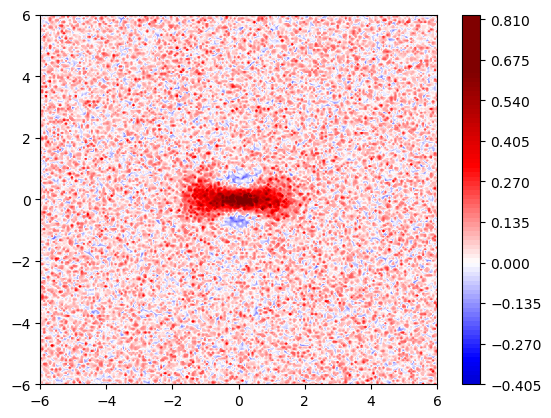

In [4]:
state = cat_factory(2)
xvec, yvec, wigner = dq.wigner(state)

a = 1
b = 0.01
sigma = 0.1
noise = np.random.normal(0.0, scale=sigma, size=wigner.shape)

wigner_noisy = a*wigner + b*np.ones_like(wigner) + noise

plot_wigner(xvec, yvec, wigner_noisy)






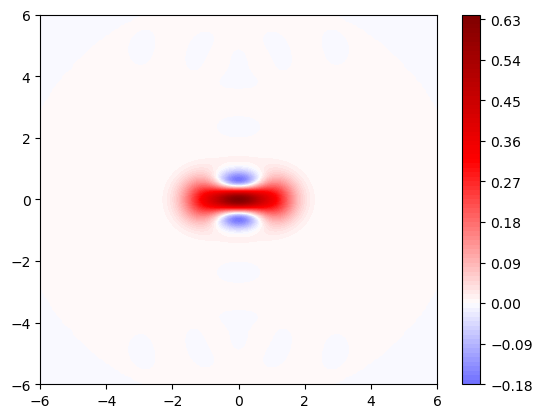

In [8]:
plot_wigner(xvec, yvec, wigner)

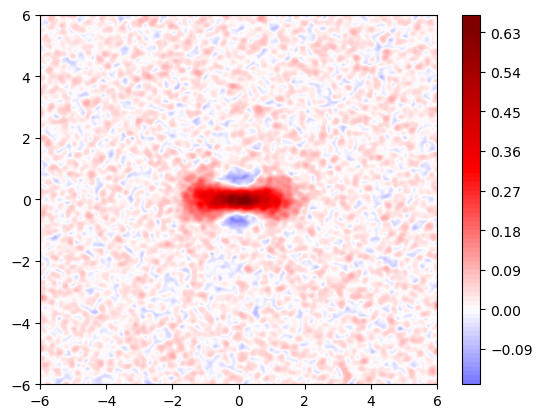

In [17]:
from scipy.ndimage import gaussian_filter

smoothing_sigma = 1.0
wigner_filtered = gaussian_filter(wigner_noisy, sigma=smoothing_sigma)


plot_wigner(xvec, yvec, wigner_filtered)

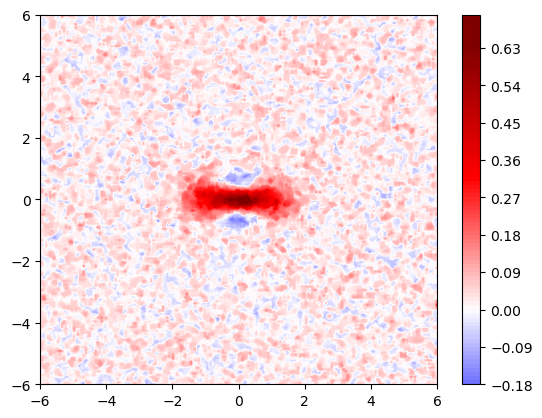

In [16]:
from scipy.ndimage import median_filter

# apply a 3×3 median filter
wigner_med = median_filter(wigner_noisy, size=(3,3))
plot_wigner(xvec, yvec, wigner_med)

In [18]:
from skimage.restoration import denoise_nl_means, estimate_sigma

# estimate noise standard deviation from the data
sigma_est = np.mean(estimate_sigma(wigner_noisy, multichannel=False))
# patch_kw: controls patch size and search window
wigner_nlm = denoise_nl_means(
    wigner_noisy,
    h=1.15 * sigma_est,
    patch_size=5,
    patch_distance=6,
    multichannel=False
)
plot_wigner(xvec, yvec, wigner_nlm)

ImportError: cannot import name 'AxisError' from 'scipy._lib._util' (/Users/fabianschatz/miniconda3/envs/qutip/lib/python3.12/site-packages/scipy/_lib/_util.py)

jaxlib.xla_extension.ArrayImpl

In [19]:
from scipy.signal import wiener


# local Wiener filter
wigner_wien = wiener(np.array(wigner_noisy), mysize=(5,5), noise=None)
plot_wigner(xvec, yvec, wigner_wien)

ImportError: cannot import name '_sub_module_deprecation' from 'scipy._lib.deprecation' (/Users/fabianschatz/miniconda3/envs/qutip/lib/python3.12/site-packages/scipy/_lib/deprecation.py)